In [1]:
from sklearn import linear_model
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import numpy as np
import seaborn as sns
import urllib
import math
import sys

%matplotlib inline

# Exercice 1

### 1) Récupérer les données

In [2]:
def check_or_download_file(fullpath):
    filename = path.basename(fullpath)
    if sys.version_info >= (3, 0):
        if not(path.isfile(filename)):
            urllib.request.urlretrieve(fullpath, filename)
    else:
        if not(path.isfile(filename)):
            urllib.urlretrieve(fullpath, filename)

In [3]:
# Download and read file
filename = "Galton.txt"
check_or_download_file("http://josephsalmon.eu/enseignement/TELECOM/MDI720/datasets/" + filename)
df = pd.read_csv(filename, sep='\t')

# Switch to cm and round
df[['Father', 'Mother', 'Height']] = df[['Father', 'Mother', 'Height']] * 2.54
df = df.round({'Father' : 0, 'Mother' : 0, 'Height' : 0})
number_of_observations, p = df.shape

print("Number of observations = " + str(number_of_observations))
df.head()

Number of observations = 898


,Family,Father,Mother,Gender,Height,Kids
0,1,199.0,170.0,M,186.0,4
1,1,199.0,170.0,F,176.0,4
2,1,199.0,170.0,F,175.0,4
3,1,199.0,170.0,F,175.0,4
4,2,192.0,169.0,M,187.0,4


### 2) Combien de données manquantes

In [4]:
print("Total Number of rows with NA values:", df.isnull().values.ravel().sum())

Total Number of rows with NA values: 0


### 3) Afficher sur un même graphique un estimateur de la densité

In [5]:
# split mother's and father's data heights
grouped_by_family_df = df.groupby(df['Family'])
father_df = grouped_by_family_df.first()['Father']
mother_df = grouped_by_family_df.first()['Mother']

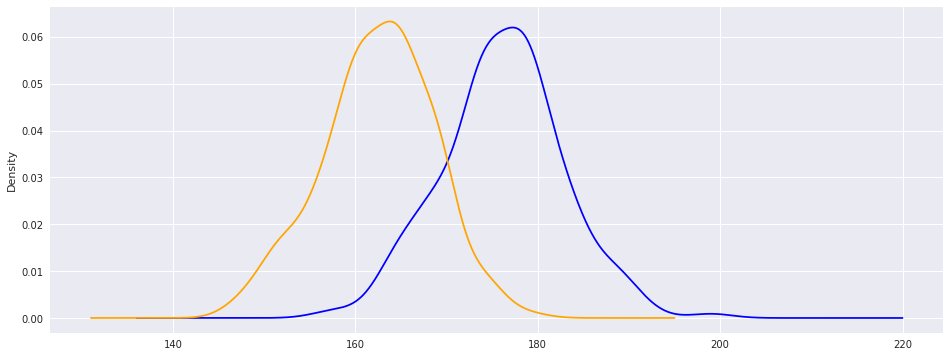

In [6]:
# Plot kernel density estimates of heights
sns.set()
fig, ax = plt.subplots(figsize=(16,6))

father_df.plot.kde(ax=ax, color='blue', fillstyle='full', markerfacecolor='red', label='Father\'s height denisties')
mother_df.plot.kde(ax=ax, color='orange', label='Mother\'s height denisties')


### 4) Afficher la taille du père en fonction de la taille de la mère

In [7]:
# Utility function
def display_legend():
    legend = plt.legend(frameon=True)
    legend_frame = legend.get_frame()
    legend_frame.set_color('white')
    legend_frame.set_edgecolor('black')

Ordonnée à l'origine = 146.719584513


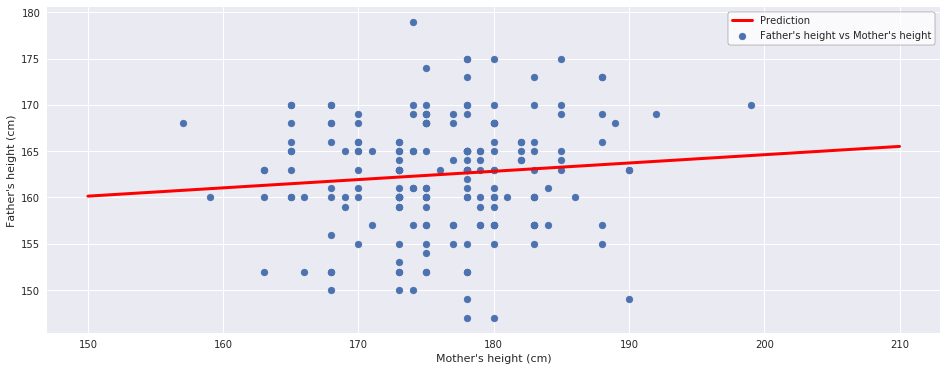

In [8]:
# On affiche la taille du père en fonction de celle de la mère
fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(father_df, mother_df, label="Father's height vs Mother's height")
ax.set_xlabel("Mother's height (cm)")
ax.set_ylabel("Father's height (cm)")

model = linear_model.LinearRegression(fit_intercept=True)
model.fit(father_df[:, np.newaxis], mother_df.values)
xs = np.linspace(150.0, 210.0, num=2)
X_to_predict = xs.reshape(len(xs), 1)

print("Ordonnée à l'origine = " + str(model.intercept_))
ax.plot(X_to_predict, model.predict(X_to_predict), linewidth=3, label="Prediction", color='red')
display_legend()

### 5) Afficher un histogramme du nombre d'enfants par famille

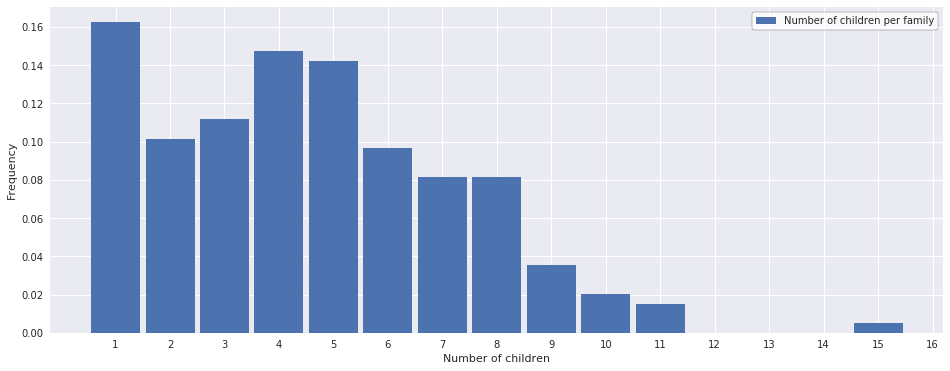

In [9]:
number_of_children_by_family = grouped_by_family_df['Kids'].first()

# plot
bins = np.arange(1, 17)
fig, ax = plt.subplots(figsize=(16,6))
counts, edges, patches = plt.hist(number_of_children_by_family, normed=True, bins=bins, label="Number of children per family", rwidth=0.9, align='left')
ax.set_xlabel("Number of children")
ax.set_ylabel("Frequency")
plt.xticks(bins)
display_legend()

### 6) Colonne supplémentaire MidParents

In [10]:
df['MidParents'] = (df['Father'] + 1.08 * df['Mother']) / 2

### 7) Estimation de Teta0 et Teta1

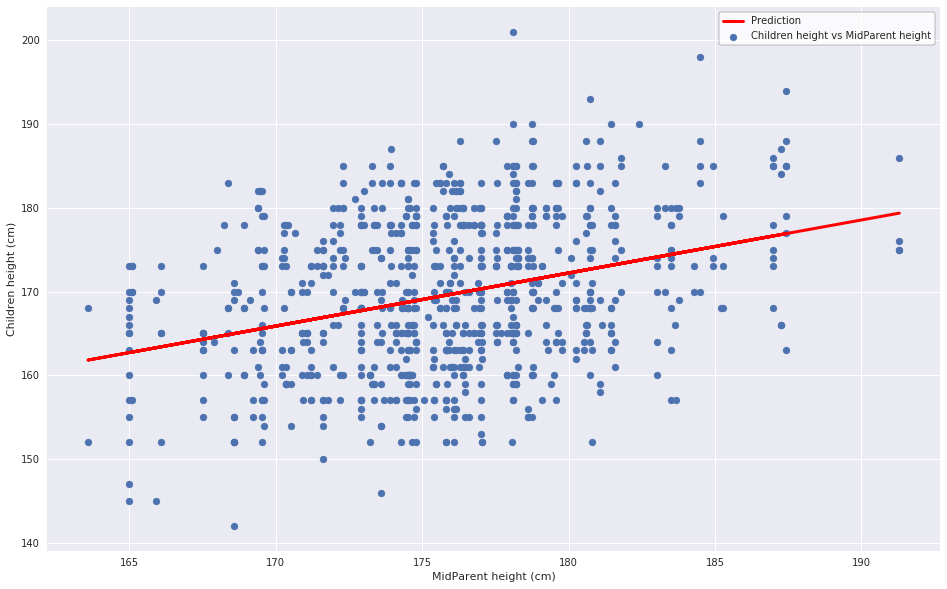

In [11]:
x = df['MidParents']
X = x[:, np.newaxis]
y = df['Height']

model = linear_model.LinearRegression(fit_intercept=True)
model.fit(X, y)

# plotting
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(X, y, label="Children height vs MidParent height")
ax.set_xlabel("MidParent height (cm)")
ax.set_ylabel("Children height (cm)")
ax.plot(X, model.predict(X), linewidth=3, label="Prediction", color='red')
display_legend()

**Verification numérique**

In [12]:
teta0 = model.intercept_
teta1 = model.coef_[0]

ybar = y.mean()
xbar = x.mean()

def check_teta0():
    teta0_calc = ybar - xbar * teta1
    print("calculated teta0 = " + str(teta0_calc))
    print("scikitlearn teta0 = " + str(teta0))
    if (np.isclose(teta0, teta0_calc)):
        print("Teta0 has been estimated correctly")
    else:
        print("Teta0 has not been estimated correctly")
        
def check_teta1():
    teta1_calc = ((x - xbar) * (y - ybar)).sum() / ((x - xbar) ** 2).sum()
    print("estimated teta1 = " + str(teta1_calc))
    print("scikitlearn teta1 = " + str(teta1))
    if (np.isclose(teta1, teta1_calc)):
        print("Teta1 has been estimated correctly")
    else:
        print("Teta1 has not been estimated correctly")
        
check_teta0()
print()
check_teta1()

calculated teta0 = 58.255916588
scikitlearn teta0 = 58.255916588
Teta0 has been estimated correctly

estimated teta1 = 0.633093766663
scikitlearn teta1 = 0.633093766663
Teta1 has been estimated correctly


### 8) Calculer et visualiser les valeurs prédites vs les observations

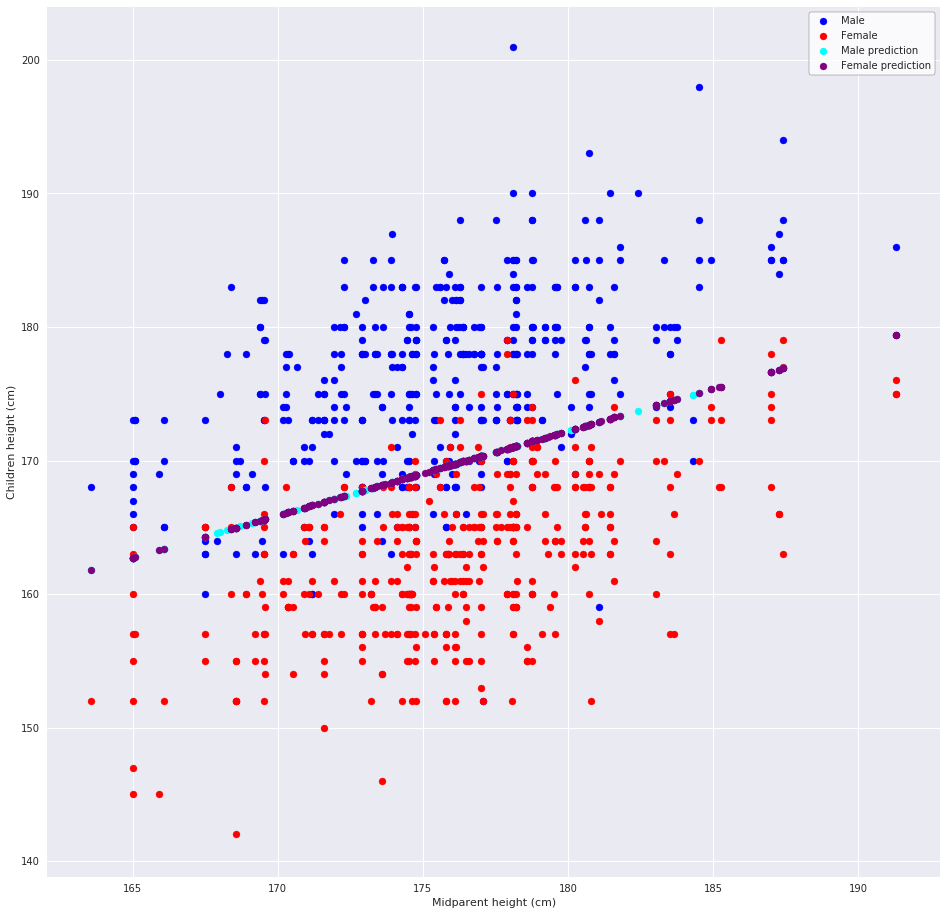

In [13]:
male_data = df[df['Gender'] == 'M']
female_data = df[df['Gender'] == 'F']
x_male = male_data['MidParents']
x_female = female_data['MidParents']
y_male = male_data['Height']
y_female = female_data['Height']

y_male_estim = teta0 + teta1 * x_male
y_female_estim = teta0 + teta1 * x_female

fig, ax = plt.subplots(figsize=(16,16))
ax.set_xlabel('Midparent height (cm)')
ax.set_ylabel('Children height (cm)')
ax.scatter(x_male, y_male, color='blue', label="Male")
ax.scatter(x_female, y_female, color='red', label="Female")

ax.scatter(x_male, y_male_estim, color='cyan', label="Male prediction")
ax.scatter(x_female, y_female_estim, color='purple', label="Female prediction")

display_legend()

### 9) Estimateur de la densité des résidus

In [14]:
def kde_sklearn(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    x_grid = np.linspace(-40, 40, len(x))
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return (np.exp(log_pdf), x_grid)

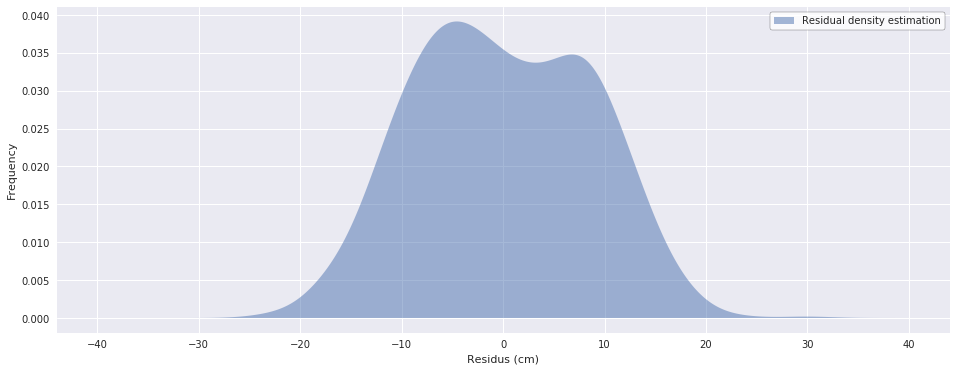

In [15]:
y_estim = teta0 + teta1 * x
r = y - y_estim

dens, x_grid = kde_sklearn(r, bandwidth=2.5)

fig, ax = plt.subplots(figsize=(16,6))
ax.fill(x_grid, dens, alpha=0.5, label="Residual density estimation")
ax.set_xlabel("Residus (cm)")
ax.set_ylabel("Frequency")
display_legend()

###### L'hypothèse de normalité est-elle crédible selon vous ?

- On constate que la densité des résidus ne suit pas une loi normale. L'hypothèse de normalité n'est donc pas respectée.

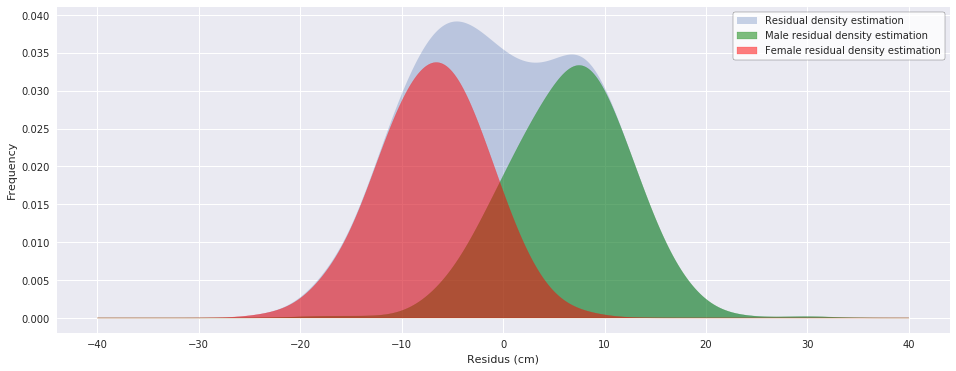

In [16]:
alpha_male = len(y_male) / number_of_observations
alpha_female = len(y_female) / number_of_observations
r_male = y_male - y_male_estim
r_female = y_female - y_female_estim

male_dens, x_male_grid = kde_sklearn(r_male, bandwidth=2.5)
female_dens, x_female_grid = kde_sklearn(r_female, bandwidth=2.5)

fig, ax = plt.subplots(figsize=(16,6))
ax.fill(x_grid, dens, alpha=0.3, label="Residual density estimation")
ax.fill(x_male_grid, alpha_male * male_dens, color='green', alpha=0.5, label="Male residual density estimation")
ax.fill(x_female_grid, alpha_female * female_dens, color='red', alpha=0.5, label="Female residual density estimation")

ax.set_xlabel("Residus (cm)")
ax.set_ylabel("Frequency")

display_legend()

L'hypothèse de normalité se confirme lorsque l'on sépare notre jeux de données en deux parties (une pour les hommes et une pour les femmes).

### 10) Régression de X sur Y

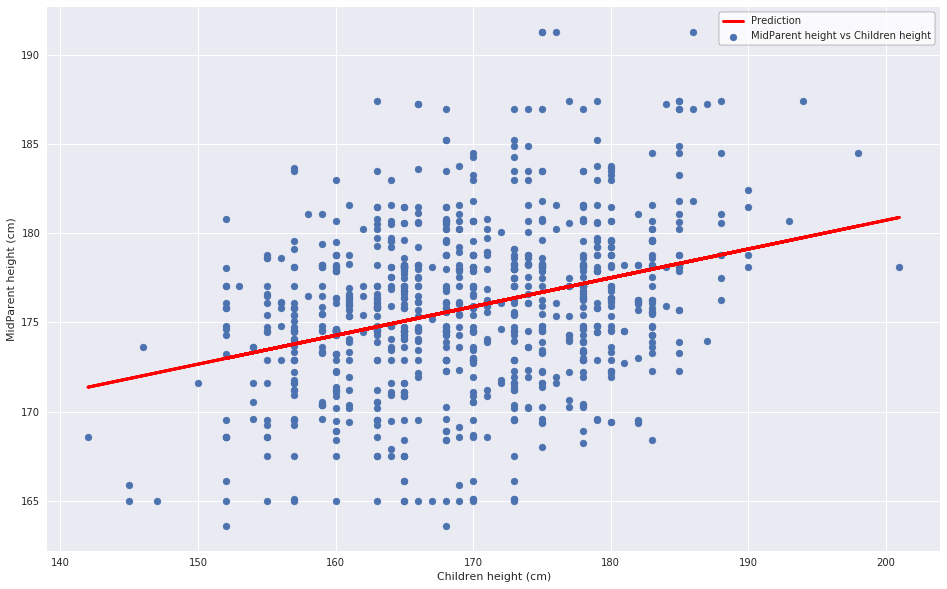

In [17]:
x = df['MidParents']
y = df['Height']
Y = y.values.reshape(len(y), 1)

model = linear_model.LinearRegression(fit_intercept=True)
model.fit(Y, x)

# plotting
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(Y, x, label="MidParent height vs Children height")
ax.set_xlabel("Children height (cm)")
ax.set_ylabel("MidParent height (cm)")
ax.plot(Y, model.predict(Y), linewidth=3, label="Prediction", color='red')

display_legend()

**Verification numérique**

In [18]:
alpha0 = model.intercept_
alpha1 = model.coef_[0]

ybar = y.mean()
xbar = x.mean()

def check_alpha0():
    alpha0_calc = xbar + ((ybar / xbar) * (np.var(x) / np.var(y)) * (teta0 - ybar))
    print("calculated alpha0 = " + str(alpha0_calc))
    print("scikitlearn alpha0 = " + str(alpha0))
    if (np.isclose(alpha0, alpha0_calc)):
        print("alpha0 has been estimated correctly")
    else:
        print("alpha0 has not been estimated correctly")
        
def check_alpha1():
    alpha1_calc = (np.var(x) / np.var(y)) * teta1
    print("estimated alpha1 = " + str(alpha1_calc))
    print("scikitlearn alpha1 = " + str(alpha1))
    if (np.isclose(alpha1, alpha1_calc)):
        print("alpha1 has been estimated correctly")
    else:
        print("alpha1 has not been estimated correctly")
        
check_alpha0()
print()
check_alpha1()

calculated alpha0 = 148.437160448
scikitlearn alpha0 = 148.437160448
alpha0 has been estimated correctly

estimated alpha1 = 0.161490302931
scikitlearn alpha1 = 0.161490302931
alpha1 has been estimated correctly


# Exercice2

### 11) Import de la base de données

In [19]:
filename_auto = "auto-mpg.data-original"
check_or_download_file("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/" + filename_auto)

df_conso_auto = pd.read_csv(filename_auto, na_values=['NA'], sep=r'\s+', names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name'])
df_conso_auto.dropna(inplace=True)
df_conso_auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


### 12) Calcul de l'estimateur des moindres carrés

*les colonnes de X sont les régresseurs quantitatifs, donc pour le moment on laisse de côté les variables origin et car name*

In [20]:
features = df_conso_auto.columns[1:7]
features_df_auto = df_conso_auto[features]

def train_model(X, y, fit_intercept=True):
    model = linear_model.LinearRegression(fit_intercept=fit_intercept)
    model.fit(X, y)
    return model

def print_reg_coef(linmodel, df):
    columns = df.columns
    coef_names = {}
    print("Coefficients de la régression dans l'ordre d'importance:")
    for i, coef in enumerate(linmodel.coef_):
        coef_names[columns[i]] = coef
    sorted_coef = sorted(coef_names.items(), key=lambda x:math.fabs(x[1]), reverse=True)
    for kvp in sorted_coef:
        print(kvp[0] + ' = ' + str(kvp[1]))

# On crée et on entraine le modèle
model = train_model(features_df_auto[:9], df_conso_auto['mpg'][:9])

# On effectue la prédiction
prediction = model.predict(features_df_auto[:9])
print("Prediction sur les 9 premières lignes:")
print(prediction)

print()
print_reg_coef(model, features_df_auto)

Prediction sur les 9 premières lignes:
[ 17.83593432  16.15135218  17.02803274  16.08414928  17.15247702
  14.85588522  14.27266143  14.2658702   13.35363761]

Coefficients de la régression dans l'ordre d'importance:
acceleration = -0.199367012686
horsepower = -0.094530596162
displacement = 0.0540884756683
weight = -0.00424073670631
model_year = 0.0
cylinders = 0.0


**On constate que les coefficients de régression associés aux variables cylinders et model_year sont à 0 ce qui implique qu'elles n'ont aucun impact dans l'explication de la variable de consommation si on ne considère que les 9 premières lignes.**

### 13) Regréssion sur l'ensemble des données

In [21]:
from sklearn import preprocessing

# On centre et on réduit nos observations
scaller = preprocessing.StandardScaler()
X = pd.DataFrame(scaller.fit_transform(features_df_auto), columns=features_df_auto.columns)
y = df_conso_auto['mpg']

# On crée et on entraine le modèle
model2 = train_model(X, y)

# On effectue la prédiction
y_chapeau = model2.predict(X)

print("Prédictions (10 premières):")
print(y_chapeau[:10])
print()
print_reg_coef(model2, features_df_auto)

Prédictions (10 premières):
[ 15.08291904  14.07257469  15.53631544  15.53447451  15.28640745
  10.13543367  10.14518132  10.2823774    9.75375835  13.04735326]

Coefficients de la régression dans l'ordre d'importance:
weight = -5.76399971331
model_year = 2.77166414653
displacement = 0.802476155407
cylinders = -0.561949960954
acceleration = 0.234957036623
horsepower = -0.0150445037695


**Les deux variables qui ont le plus d'impact sur la consommation soient les variables "weight" et "model_year" car ce sont elles qui ont les coefficients de régression linéraire les plus élevés en valeur absolue**

### 14) Vérification du calcul

In [22]:
residus = y - y_chapeau
norm_residus = np.linalg.norm(residus)
n, p = X.shape
ybar = y.mean()
ones = np.ones(len(y))

print("||r||² = " + str(norm_residus ** 2))
print("||r||² / (n - p) = " + str(norm_residus ** 2 / (n - p)))

norm_centered_y = np.linalg.norm(y - ybar)
norm_centered_y_chapeau = np.linalg.norm(y_chapeau - ybar)

print()
left = norm_centered_y ** 2
right = norm_residus ** 2 + norm_centered_y_chapeau ** 2

if np.isclose(left, right):
    print("Equation is verified")
else:
    print("Equation not verified")

||r||² = 4543.34702471
||r||² / (n - p) = 11.7703290796

Equation is verified


### 15) Prédire la consommation d'un nouveau véhicule

In [23]:
new_x = np.array([6.0, 225.0, 100.0, 3233.0, 15.4, 76.0])
# on normalize notre vecteur d'observations
to_predict = scaller.transform(new_x[np.newaxis,:])

normalized_predicition = model2.predict(to_predict)

print("Notre prédiction sur la consommation du véhicule est:")
print(normalized_predicition[0])

Notre prédiction sur la consommation du véhicule est:
21.7762201826


### 16) Modèle d'ordre 2

In [24]:
def get_polynomial_coef(df, poly, coef):
    columns = df.columns
    poly_names = poly.get_feature_names()
    poly_name_to_column_name = dict()
    poly_features = poly.get_feature_names()[1:]
    for i, name in enumerate(columns):
        poly_name_to_column_name['x' + str(i)] = name
    for i, name in enumerate(columns):
        poly_name_to_column_name['x' + str(i) + '^2'] = name + '^2'
    for i, namei in enumerate(columns):
        for j, namej in enumerate(columns):
            poly_name_to_column_name['x' + str(i) + ' x' + str(j)] = namei + ' ' + namej
    result = {}
    for i, poly_name in enumerate(poly_features):
        feature_name = poly_name_to_column_name[poly_name]
        result[feature_name] = coef[i]
    return result

# On récupère la combinaison polynomiale de nos features à l'ordre 2
poly = preprocessing.PolynomialFeatures()
poly_features = poly.fit_transform(features_df_auto)

# On ne garde pas la première colonne de features qui correspond à la constante
poly_features = poly_features[:,1:]

# On normalise les nouvelles données
scaller2 = preprocessing.StandardScaler()
normalized = scaller2.fit_transform(poly_features)

# on construit un nouveau modèle
model3 = train_model(normalized, y)
import math
poly_feature_names = get_polynomial_coef(features_df_auto, poly, model3.coef_)

print("Les coefficients de la regression dans l'ordre d'importance (en valeur absolue) sont:")
print()
sorted_features_coef = sorted(poly_feature_names.items(), key=lambda x:math.fabs(x[1]), reverse=True)
for kvp in sorted_features_coef:
    print(kvp[0] + ' = ' + str(kvp[1]))


Les coefficients de la regression dans l'ordre d'importance (en valeur absolue) sont:

displacement = -48.4339134142
displacement model_year = 43.6843143243
model_year^2 = 29.8485113499
model_year = -26.881048214
weight model_year = -25.1160626903
weight = 17.4709166661
cylinders model_year = -16.2292812842
acceleration = -16.0507252845
acceleration model_year = 13.9136130186
cylinders = 13.3435753601
cylinders horsepower = 11.9517421828
cylinders^2 = -8.13486672673
horsepower weight = -6.15116573498
cylinders weight = 5.33737454853
displacement weight = 5.204741301
horsepower = 5.15417707108
cylinders acceleration = 4.87668633933
horsepower model_year = -4.85057027223
horsepower^2 = -3.59171564879
displacement horsepower = 3.38005168496
displacement acceleration = -3.29326442826
weight^2 = 3.1582299655
cylinders displacement = -2.94736774335
horsepower acceleration = -2.38675584655
acceleration^2 = 1.99403566814
displacement^2 = 1.29969118081
weight acceleration = 0.849189126384


**On constate clairement que pour le modèle d'ordre 2 la variable la plus explicative de la consommation est la variable "displacement" car c'est elle qui a le plus grand coefficient de régression linéaire**

### 17) Gestion de la variable "origin" dans le modèle sans interactions

In [25]:
# On reconstruit notre dataframe de features sans la variable explicative
# et avec la variable origin
features = df_conso_auto.columns[1:8]
features_df = df_conso_auto[features]

# On remplace la variable origin par des dummies
df_with_dummies = pd.get_dummies(features_df, prefix='origin', columns=['origin'], drop_first=True)

# On normalise les nouvelles données
scaller = preprocessing.StandardScaler()
normalized = scaller.fit_transform(df_with_dummies)

# on construit un nouveau modèle
model3 = train_model(normalized, y, fit_intercept=False)

print_reg_coef(model3, df_with_dummies)

Coefficients de la régression dans l'ordre d'importance:
weight = -5.69254263882
model_year = 2.85870922689
displacement = 2.50601873822
origin_3.0 = 1.14455366262
origin_2.0 = 0.995857119732
cylinders = -0.834271968964
horsepower = -0.699009319443
acceleration = 0.217955989651


**Après avoir enlevé la première variable de la régression linéaire (orginine = 1, usa), on  s'apercoit que les coefficients pour les origines 2 et 3 sont positifs. Ces deux origines ont donc un impact plus important que l'origine USA (sinon les coefficients seraient négatifs). L'origine qui a le plus d'impact sur la consommation est l'origine 3 (Japon) car c'est le coefficient le plus fort en valeur absolue. Les voitures japonaises sont également les plus efficaces en terme de consommation car le coefficient est le plus important (strictement positif). On parcourt donc plus de miles avec une voiture japonaise pour un galon d'essence que pour les autres origines.** 

### 18) Mésurer l'influence de la marque de la voiture

In [26]:
df = df_conso_auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model_year', 'car_name']]
df.is_copy = False

def extract_brand(name):
    brand = name.split(" ")[0]
    brand = brand.replace('toyouta', 'toyota')
    brand = brand.replace('vw', 'volkswagen')
    brand = brand.replace('vokswagen', 'volkswagen')
    brand = brand.replace('mercedens-benz', 'mercedes')
    brand = brand.replace('chevroelt', 'chevrolet')
    brand = brand.replace('chevy', 'chevrolet')
    brand = brand.replace('maxda', 'mazda')
    return brand

extracted_cars = df['car_name'].apply(extract_brand)
df['car_name'] = extracted_cars

df_with_dummies = pd.get_dummies(df, prefix='car_name', columns=['car_name'], drop_first=True)

# On normalise les nouvelles données
scaller = preprocessing.StandardScaler()
normalized = scaller.fit_transform(df_with_dummies)

# On entraine le modèle
model = train_model(normalized, y, fit_intercept=False)

print_reg_coef(model, df_with_dummies)

Coefficients de la régression dans l'ordre d'importance:
weight = -5.41197567104
model_year = 2.75264322129
displacement = 2.64639389915
car_name_datsun = 1.37431355263
car_name_volkswagen = 1.13833430872
cylinders = -1.05994742263
horsepower = -0.946062064451
car_name_honda = 0.927461085903
car_name_toyota = 0.872648602228
car_name_plymouth = 0.755874100915
car_name_fiat = 0.688779052538
car_name_pontiac = 0.572587625067
car_name_audi = 0.556989983062
car_name_mazda = 0.555779353147
car_name_dodge = 0.553750379891
car_name_peugeot = 0.525803497099
car_name_chevrolet = 0.440764300734
car_name_triumph = 0.431870120595
car_name_oldsmobile = 0.39294408394
car_name_renault = 0.388420166695
car_name_subaru = 0.346997910047
car_name_saab = 0.340690354526
car_name_mercedes-benz = 0.327502881769
car_name_nissan = 0.301321419987
car_name_cadillac = 0.282345794305
car_name_buick = 0.263359062605
car_name_mercedes = 0.245370238947
car_name_ford = 0.242440281488
car_name_opel = 0.236860646831
car_

**Une fois la marque de la voiture intégrée à la régression, on s'appercoit que le poids et l'année restent les variables les plus impactantes. Les marques "datsun" suivi de "volkswagen" sont les deux marques qui ont le plus d'impacte sur la consommation.**

### 19) Calcul de la SVD

In [27]:
U, s, V = np.linalg.svd(X, full_matrices=False)

H = U.dot(U.T)
H2 = H.dot(H)

if np.all(np.isclose(H, H2)) and np.all(np.isclose(H, H.T)):
    print("H est une projection orthogonale")
else:
    print("H n'est pas une projection orthogonale")

H est une projection orthogonale


### 20) Vecteur des leviers

In [28]:
leviers = np.diag(H)
df.is_copy = False
df['leviers'] = list(leviers)
df['residus'] = list(y_chapeau - y)
df['mpg'] = list(y)
with_leverages = df.sort_values('leviers', ascending=False)[:3]
with_leverages

,cylinders,displacement,horsepower,weight,acceleration,model_year,car_name,leviers,residus,mpg
19,8.0,455.0,225.0,3086.0,10.0,70.0,buick,0.187359,4.851752,14.0
34,8.0,304.0,193.0,4732.0,18.5,70.0,hi,0.084799,-1.754286,9.0
32,8.0,307.0,200.0,4376.0,15.0,70.0,chevrolet,0.061549,-0.613563,10.0


On constate que ces 3 observations sont atypiques car elles s'éloignent de la moyenne des observations. Pour s'en convaincre on peut afficher les valeurs pour chaque variable des ces 3 observations au regard des distributions globales.

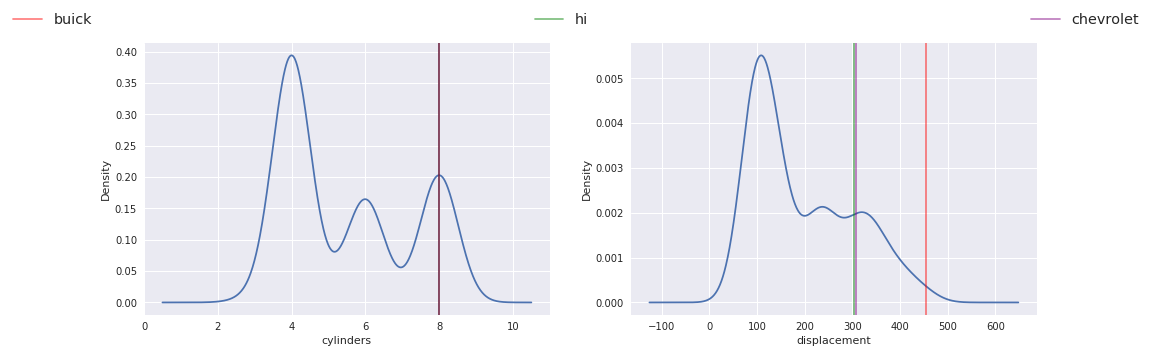

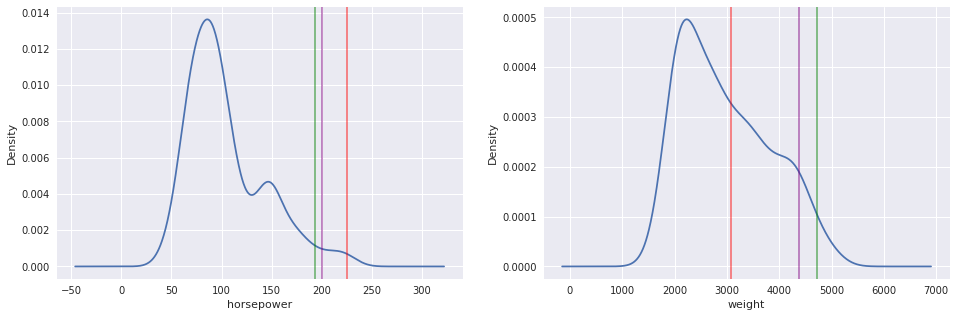

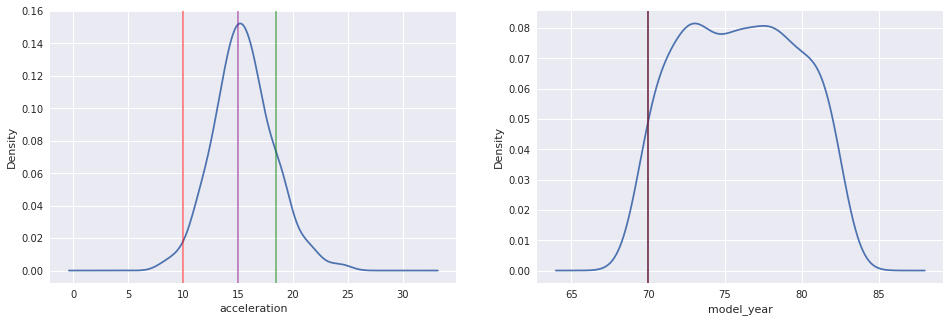

In [29]:
def plot_distributions(columns):
    all_axes = []
    for i, column in enumerate(columns):
        if i % 2 == 0:
            fig, axes = plt.subplots(ncols=2, figsize=(16,5))
        df[column].plot.kde(ax=axes[i % 2], label=column)
        axes[i % 2].set_xlabel(column)
        axes[i % 2].set_label(column)

        all_axes.append((fig, axes[i % 2]))
    return all_axes

def display_values(color, row, axes, lines):
    for i, col in enumerate(row):
        line = axes[i][1].axvline(col, color=color, alpha=0.5, label=color)
        if i == 0:
            lines.append(line)

buick_row = with_leverages.iloc[0, :][X.columns]
hi_row = with_leverages.iloc[1, :][X.columns]
chevrolet_row = with_leverages.iloc[2, :][X.columns]

axes = plot_distributions(X.columns)
lines = []
display_values('red', buick_row, axes, lines)
display_values('green', hi_row, axes, lines)
display_values('purple', chevrolet_row, axes, lines)

axes[0][0].legend(labels=['buick', 'hi', 'chevrolet'], handles=lines, loc=9, ncol=3, mode="expand", fontsize='large')

**A la vue de cette aide visuelle, on se rend bien compte que ces 3 voitures sont atypiques pour les variables suivantes:**
- **buick => "displacement", "horsepower", "acceleration"**
- **hi => "horsepower", "weight"**
- **chevrolet => "horsepower", "weight", "acceleration"**